# Multilevel Regression and Post-stratification

## Load libraries

In [25]:
import warnings

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

## Load data

In [2]:
df = pd.DataFrame(
    {
        "name": [
            "Rheia",
            "Kronos",
            "Demeter",
            "Hades",
            "Hestia",
            "Poseidon",
            "Hera",
            "Zeus",
            "Artemis",
            "Apollo",
            "Leto",
            "Ares",
            "Athena",
            "Hephaestus",
            "Aphrodite",
            "Cyclope",
            "Persephone",
            "Hermes",
            "Hebe",
            "Dionysus",
        ],
        "Risk_Strata": [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        "Treatment": [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        "Outcome": [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    }
)

df["Treatment_x_Risk_Strata"] = df.Treatment * df.Risk_Strata

df

,name,Risk_Strata,Treatment,Outcome,Treatment_x_Risk_Strata
0,Rheia,0,0,0,0
1,Kronos,0,0,1,0
2,Demeter,0,0,0,0
3,Hades,0,0,0,0
4,Hestia,0,1,0,0
5,Poseidon,0,1,0,0
6,Hera,0,1,0,0
7,Zeus,0,1,1,0
8,Artemis,1,0,1,0
9,Apollo,1,0,1,0


In [3]:
simple_average = df.groupby("Treatment")[["Outcome"]].mean().rename({"Outcome": "Share"}, axis=1)
simple_average

,Share
Treatment,
0,0.428571
1,0.538462


In [4]:
causal_risk_ratio = simple_average.iloc[1]["Share"] / simple_average.iloc[0]["Share"]
print("Causal Risk Ratio:", causal_risk_ratio)

Causal Risk Ratio: 1.2564102564102564


In [5]:
df.groupby("Risk_Strata")[["Treatment"]].count().assign(
    proportion=lambda x: x["Treatment"] / len(df)
)

,Treatment,proportion
Risk_Strata,,
0,8,0.4
1,12,0.6


In [6]:
# Correct by the unbalance on data

outcomes_controlled = (
    df.groupby(["Risk_Strata", "Treatment"])[["Outcome"]]
    .mean()
    .reset_index()
    .pivot(index="Treatment", columns=["Risk_Strata"], values="Outcome")
)

outcomes_controlled

Risk_Strata,0,1
Treatment,,
0,0.25,0.666667
1,0.25,0.666667


In [7]:
weighted_avg = outcomes_controlled.assign(formula="0.4*0.25 + 0.6*0.66").assign(
    weighted_average=lambda x: x[0] * (df[df["Risk_Strata"] == 0].shape[0] / len(df))
    + x[1] * (df[df["Risk_Strata"] == 1].shape[0] / len(df))
)

weighted_avg

Risk_Strata,0,1,formula,weighted_average
Treatment,,,,
0,0.25,0.666667,0.4*0.25 + 0.6*0.66,0.5
1,0.25,0.666667,0.4*0.25 + 0.6*0.66,0.5


In [8]:
causal_risk_ratio = (
    weighted_avg.iloc[1]["weighted_average"] / weighted_avg.iloc[0]["weighted_average"]
)

print("Causal Risk Ratio:", causal_risk_ratio)

Causal Risk Ratio: 1.0


## Regression stratification

In [9]:
reg = bmb.Model(
                    'Outcome ~ 1 + Treatment',
                    df
)

In [10]:
results = reg.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Outcome_sigma, Intercept, Treatment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [11]:
reg_strata = bmb.Model(
                        "Outcome ~ 1 + Treatment + Risk_Strata + Treatment_x_Risk_Strata", 
                        df
)

In [12]:
results_strata = reg_strata.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Outcome_sigma, Intercept, Treatment, Risk_Strata, Treatment_x_Risk_Strata]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [13]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.427,0.205,0.031,0.802,0.003,0.002,4426.0,3029.0,1.0
Treatment,0.112,0.259,-0.364,0.613,0.004,0.004,4902.0,2766.0,1.0
Outcome_sigma,0.544,0.092,0.387,0.716,0.002,0.001,3878.0,2644.0,1.0


In [14]:
az.summary(results_strata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.255,0.266,-0.245,0.759,0.005,0.004,2501.0,2813.0,1.0
Treatment,-0.008,0.376,-0.761,0.635,0.008,0.006,2145.0,2400.0,1.0
Risk_Strata,0.405,0.400,-0.359,1.153,0.008,0.006,2277.0,2607.0,1.0
Treatment_x_Risk_Strata,0.011,0.508,-0.893,1.021,0.012,0.008,1895.0,2211.0,1.0
Outcome_sigma,0.532,0.096,0.363,0.704,0.002,0.001,2311.0,2094.0,1.0


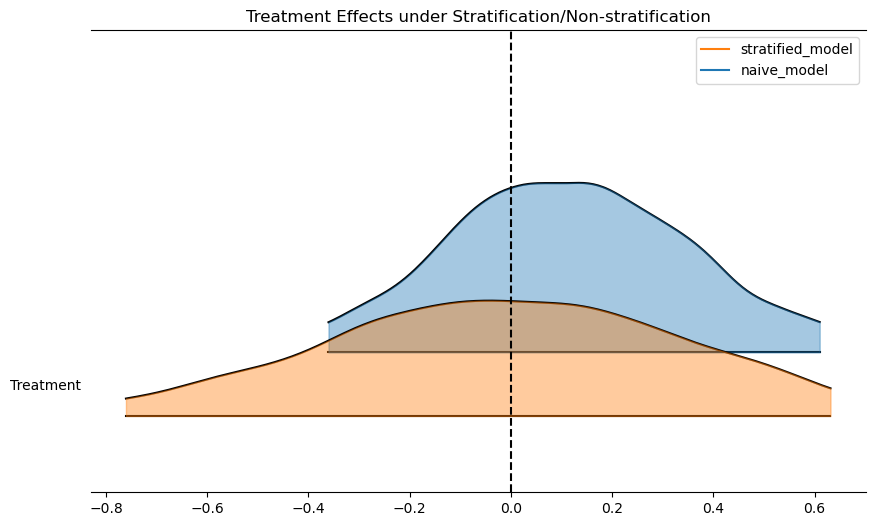

In [15]:
ax = az.plot_forest(
    [results, results_strata],
    model_names=["naive_model", "stratified_model"],
    var_names=["Treatment"],
    kind="ridgeplot",
    ridgeplot_alpha=0.4,
    combined=True,
    figsize=(10, 6),
)
ax[0].axvline(0, color="black", linestyle="--")
ax[0].set_title("Treatment Effects under Stratification/Non-stratification");

In [16]:
new_df = df[["Risk_Strata"]].assign(Treatment=1).assign(Treatment_x_Risk_Strata=1)
new_preds = reg_strata.predict(results_strata, kind="pps", data=new_df, inplace=False)
print("Expected Outcome in the Treated")
new_preds["posterior_predictive"]["Outcome"].mean().item()

Expected Outcome in the Treated


0.501834886234507

In [18]:
new_df = df[["Risk_Strata"]].assign(Treatment=0).assign(Treatment_x_Risk_Strata=0)
new_preds = reg_strata.predict(results_strata, kind="pps", data=new_df, inplace=False)
print("Expected Outcome in the Untreated")

new_preds["posterior_predictive"]["Outcome"].mean().item()

Expected Outcome in the Untreated


0.5009743095119211

## Bambi model interpretation

AttributeError: module 'bambi' has no attribute 'interpret'

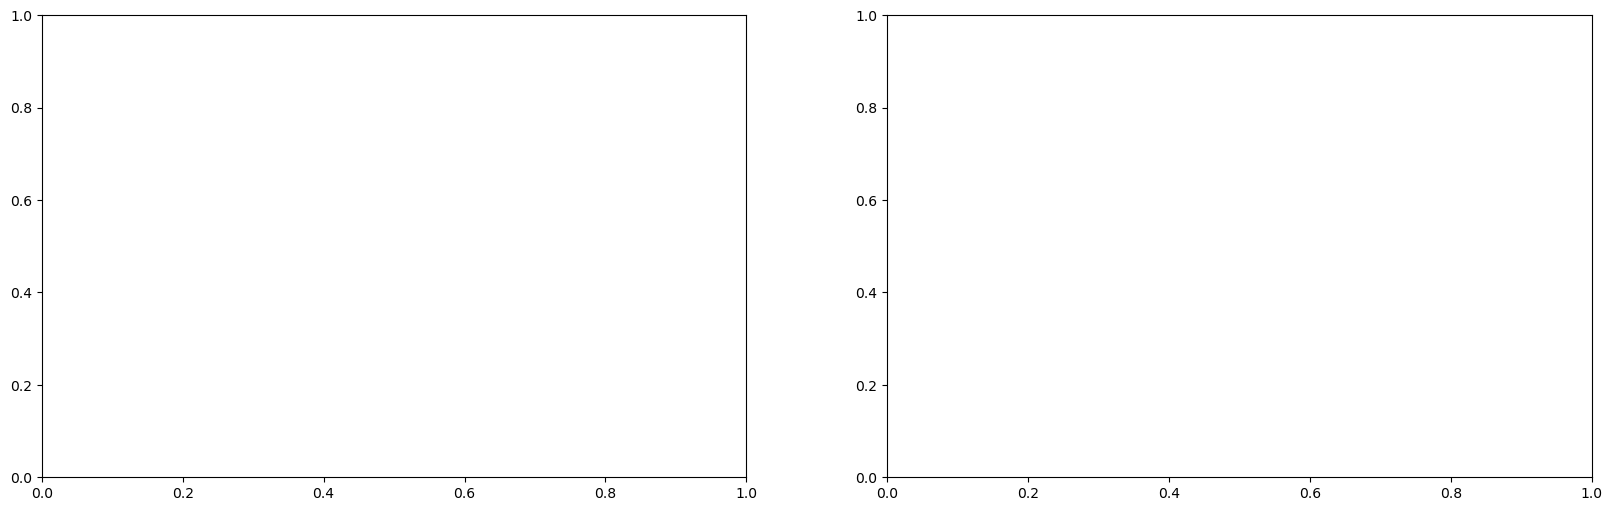

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
bmb.interpret.plot_predictions(reg, results, covariates=["Treatment"], ax=axs[0])
bmb.interpret.plot_predictions(reg_strata, results_strata, covariates=["Treatment"], ax=axs[1])
axs[0].set_title("Non Stratified Regression \n Model Predictions")
axs[1].set_title("Stratified Regression \n Model Predictions");